In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

In [2]:
warnings.filterwarnings("ignore")
df = pd.read_csv('Consumo_Energia_Mes_SE.csv', delimiter=";")
df.Data = pd.to_datetime(df.Data)
df = df.set_index("Data")
df = df.sort_index()
df.head()

,Consumo
Data,
1999-01-01,23340.17823
1999-02-01,24660.84256
1999-03-01,25243.66788
1999-04-01,24753.89075
1999-05-01,24178.69562


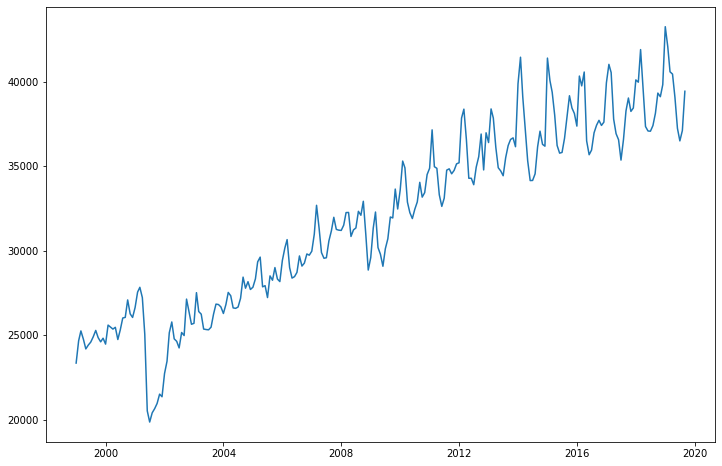

In [3]:
plt.figure(figsize=(12,8))
plt.plot(df)
plt.show()

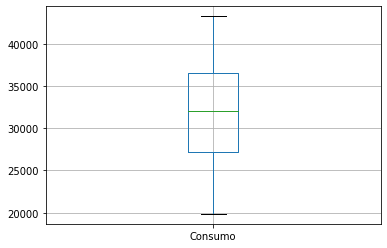

In [4]:
df.boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002AE90D85FD0>]],
      dtype=object)

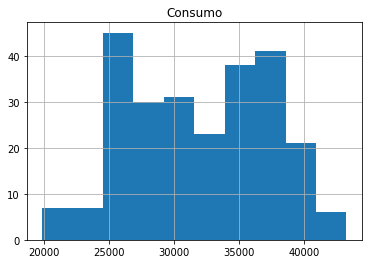

In [5]:
df.hist()

In [6]:
df.describe()

,Consumo
count,249.000000
mean,31923.312146
std,5396.606761
min,19852.428200
25%,27213.965000
50%,32087.306250
75%,36567.220600
max,43245.235300


Vamos analisar os dados de 2002 pra frente, pois parece haver inconssistência nos dados antes disso

In [7]:
df = df['2002-01-01':]
df.head()

,Consumo
Data,
2002-01-01,22719.87902
2002-02-01,23452.70220
2002-03-01,25133.20122
2002-04-01,25772.85000
2002-05-01,24774.47124


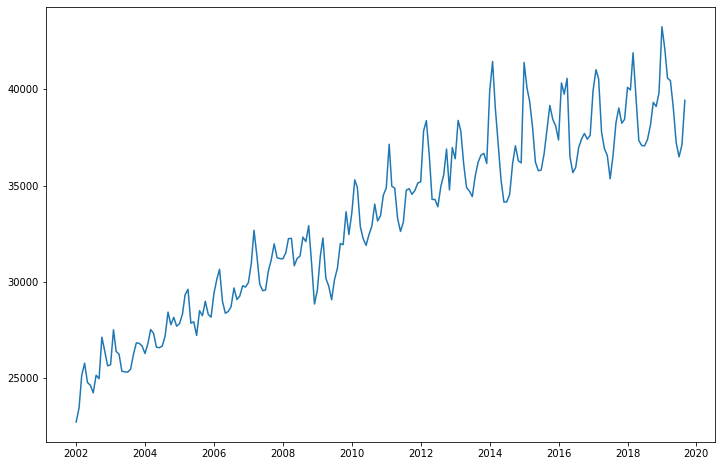

In [8]:
plt.figure(figsize=(12,8))
plt.plot(df)
plt.show()

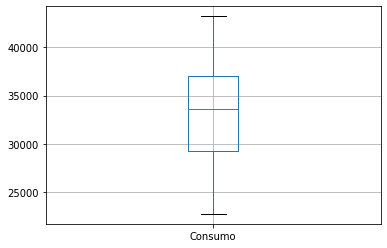

In [9]:
df.boxplot()

In [10]:
df.describe()

,Consumo
count,213.000000
mean,33173.941595
std,4738.873142
min,22719.879020
25%,29255.400050
50%,33636.323360
75%,37060.460340
max,43245.235300


In [11]:
from statsmodels.tsa.stattools import kpss
X = df.Consumo
result = kpss(X)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
	print('\t%s: %.3f' % (key, value))

KPSS Statistic: 1.413968
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


In [12]:
from statsmodels.tsa.stattools import adfuller
X = df.Consumo
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.121728
p-value: 0.706330
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575


In [13]:
from arch.unitroot import PhillipsPerron
#!pip install arch
result = PhillipsPerron(X)
result

Test Statistic,-1.954
P-value,0.307
Lags,15


In [14]:
# create a differenced series
from pandas import Series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

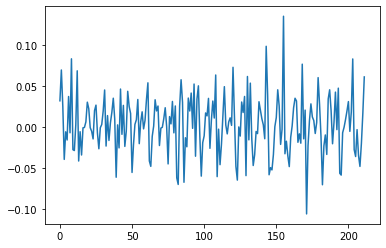

In [15]:
X = df.Consumo
df_log = np.log(X)
df_1_diff = difference(df_log)
plt.plot(df_1_diff)
plt.show()

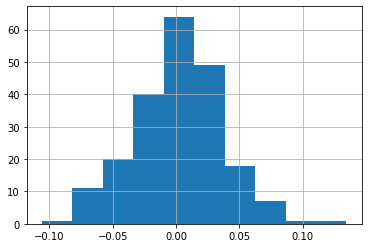

In [16]:
df_1_diff.hist()

In [17]:
result = kpss(df_1_diff)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
	print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.172000
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


In [18]:
result = adfuller(df_1_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.259344
p-value: 0.000000
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575


In [19]:
result = PhillipsPerron(df_1_diff)
result

Test Statistic,-16.620
P-value,0.000
Lags,15


In [20]:
from scipy import stats
stats.kurtosis(X)

-1.0231314693552809

In [21]:
df.head()

,Consumo
Data,
2002-01-01,22719.87902
2002-02-01,23452.70220
2002-03-01,25133.20122
2002-04-01,25772.85000
2002-05-01,24774.47124


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 213 entries, 2002-01-01 to 2019-09-01
Data columns (total 1 columns):
Consumo    213 non-null float64
dtypes: float64(1)
memory usage: 13.3 KB


In [23]:
#Creating train and test set 
#Aki vamos colocar para que ele consiga prever para os próximos 2 anos.
train=df[:len(df)-24] 
test=df[len(df)-24:]

In [24]:
test.head()

,Consumo
Data,
2017-10-01,39024.64012
2017-11-01,38233.11639
2017-12-01,38434.79185
2018-01-01,40095.31798
2018-02-01,39962.42141


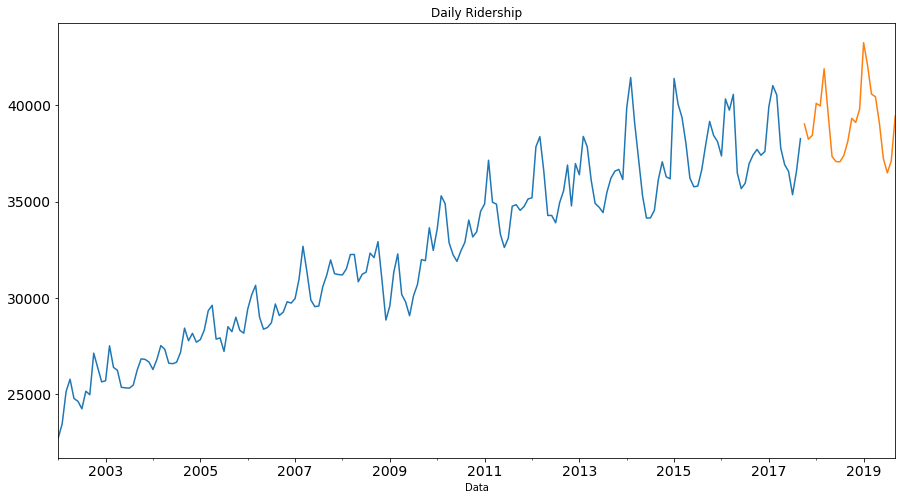

In [25]:
#Plotting data
train.Consumo.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test.Consumo.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

# Método 1: Começaremos com uma Abordagem Simples
Muitas vezes nos é fornecido um conjunto de dados que é estável durante todo o período. Se quisermos prever o Consumo de Energia para o mês seguinte, podemos simplesmente pegar o valor do último dia e estimar o mesmo valor para o dia seguinte. 
Essa técnica de previsão, que assume que o próximo ponto esperado é igual ao último ponto observado, é chamada de "Método Simples" e podemos representa-lo como na fórmula abaixo:

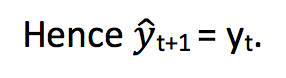

In [26]:
Image("img/Naive Method.png")

Agora vamos implementar o método Simples para prever o Consumo dos dados de teste.

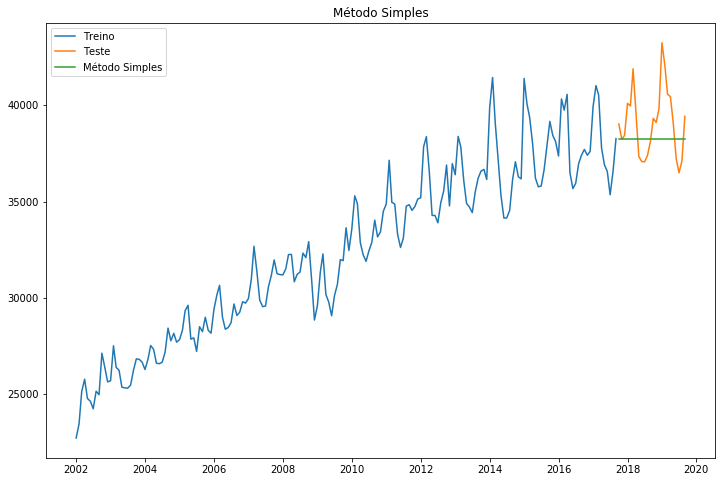

In [27]:
dd= np.asarray(train.Consumo)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Consumo'], label='Treino')
plt.plot(test.index,test['Consumo'], label='Teste')
plt.plot(y_hat.index,y_hat['naive'], label='Método Simples')
plt.legend(loc='best')
plt.title("Método Simples")
plt.show()

Agora, calcularemos o RMSE para verificar a precisão do nosso modelo no conjunto de dados de teste.

In [28]:
rms = sqrt(mean_squared_error(test.Consumo, y_hat.naive))

Vamos armazenar os resultados do RMSE para depois conseguir verificar qual foi o modelo que mais responde a essa Série temporal

In [29]:
result_NA = rms
result_NA

1908.1461483734997

# Método 2: – Média Simples

Muitas vezes nos é fornecido um conjunto de dados, que, embora varie por uma pequena margem durante o período, mas a média em cada período permanece constante. Nesse caso, podemos prever o Consumo de Energia do mês seguinte em algum lugar semelhante à média de todos os dias anteriores.

Essa técnica de previsão que prevê o valor esperado igual à média de todos os pontos observados anteriormente é chamada técnica "Média Simples" e podemos representa-lo como na fórmula abaixo:

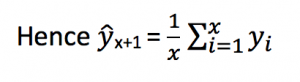

In [30]:
Image("img/Media Simples.png")

Tomamos todos os valores conhecidos anteriormente, calculamos a média e tomamos como o próximo valor. Claro que não será exato, mas um pouco próximo. Como método de previsão, existem situações em que essa técnica funciona melhor.

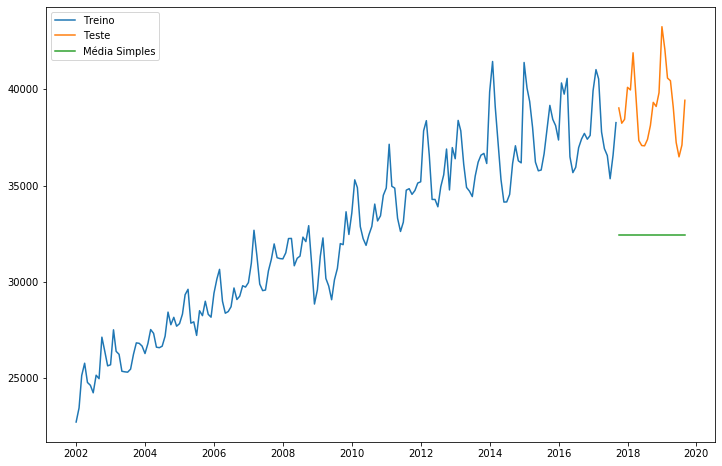

In [31]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Consumo'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['Consumo'], label='Treino')
plt.plot(test['Consumo'], label='Teste')
plt.plot(y_hat_avg['avg_forecast'], label='Média Simples')
plt.legend(loc='best')
plt.show()

In [32]:
rms = sqrt(mean_squared_error(test.Consumo, y_hat_avg.avg_forecast))
result_SA = rms
result_SA

6882.715305606959

Podemos ver que esse modelo não melhorou nossa pontuação. Portanto, podemos inferir a partir da pontuação que esse método funciona melhor quando a média em cada período de tempo permanece constante. Embora a pontuação do método Simples seja melhor que o método da Média Simples, isso não significa que o método Simples seja melhor em todos os conjuntos de dados. Devemos avançar passo a passo para cada modelo e confirmar se ele melhora ou não o nosso modelo.

# Método 3 – Média Móvel

Muitas vezes nos é fornecido um conjunto de dados, no qual os valores a serem previsto variam acentuadamente alguns períodos atrás. Para usar o método Média anterior, precisamos usar a média de todos os dados anteriores, mas o uso de todos os dados anteriores não parece correto.

O uso dos valores do Consumo de Energia do período inicial afetaria fortemente a previsão para o próximo período. Portanto, como uma melhoria em relação à média simples, consideraremos a média do Consumo apenas nos últimos períodos. Obviamente, o pensamento aqui é que apenas os valores recentes são importantes. Essa técnica de previsão que utiliza a janela do período de tempo para calcular a média é chamada de técnica Média Móvel. O cálculo da média móvel envolve o que às vezes é chamado de “janela deslizante” do tamanho n.

Usando um modelo simples de média móvel, prevemos os próximos valores do Consumo de Energia em uma série temporal com base na média de um número finito fixo 'p' dos valores anteriores. Assim, para todos os i > p

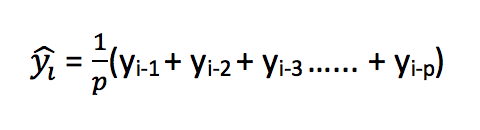

In [33]:
Image("img/Media Movel.png")

Uma média móvel pode realmente ser bastante eficaz, especialmente se você escolher o p certo para a série.

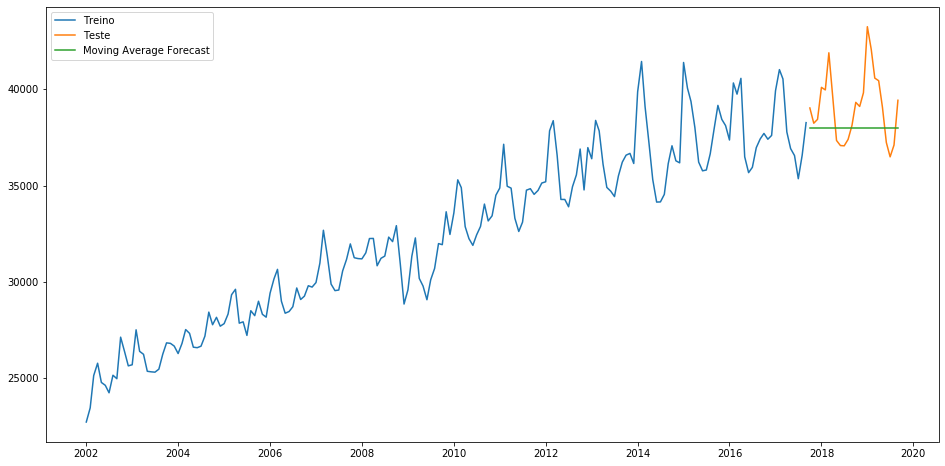

In [34]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Consumo'].rolling(12).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['Consumo'], label='Treino')
plt.plot(test['Consumo'], label='Teste')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [35]:
rms = sqrt(mean_squared_error(test.Consumo, y_hat_avg.moving_avg_forecast))
result_MA = rms
result_MA

2053.263019998794

# Método 4 - Suavização exponencial simples

Pode ser sensato atribuir pesos maiores a observações mais recentes do que a observações de um passado distante. A técnica que funciona com esse princípio é chamada de suavização exponencial simples. As previsões são calculadas usando médias ponderadas em que os pesos diminuem exponencialmente à medida que as observações vêm mais longe no passado, os pesos menores são associados às observações mais antigas como descrito na formula abaixo:

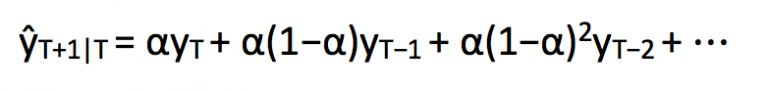

In [36]:
Image("img/SES.png")

onde 0≤ α ≤1 é o parâmetro de suavização.

A previsão um passo à frente do tempo T + 1 é uma média ponderada de todas as observações da série y1,…, yT. A taxa na qual os pesos diminuem é controlada pelo parâmetro α.

Se você o observar apenas o tempo suficiente, verá que o valor esperado ŷx é a soma de dois produtos: α⋅yt e (1-α) ⋅ŷ t-1.

Portanto, também pode ser escrito como:

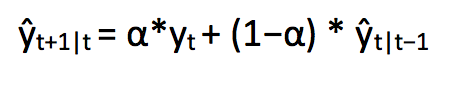

In [37]:
Image("img/SES_2.png")

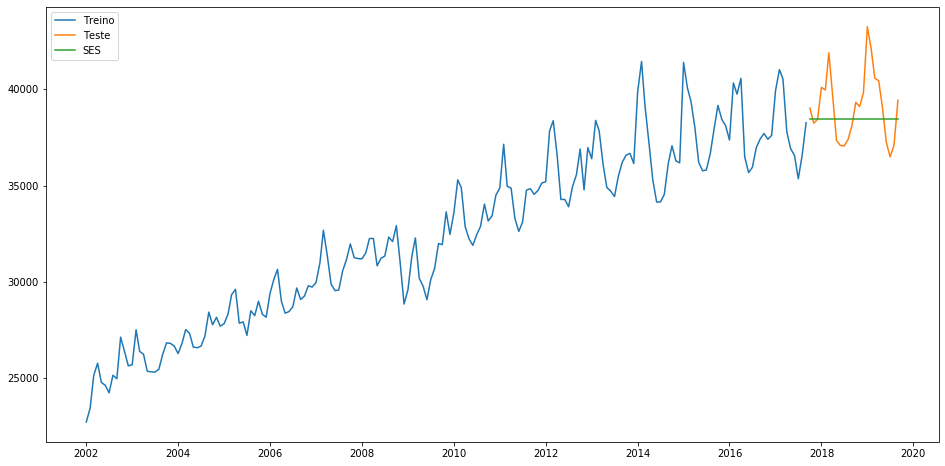

In [110]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Consumo'])).fit(smoothing_level=1.12,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Consumo'], label='Treino')
plt.plot(test['Consumo'], label='Teste')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [111]:
rms = sqrt(mean_squared_error(test.Consumo, y_hat_avg.SES))
result_SES = rms
result_SES

1836.6484828615953

# Método 5 - Tendência linear de Holt

Agora, vimos vários métodos para prever em uma série temporal, mas podemos ver que esses modelos não funcionam bem em dados com altas variações.
Se usarmos um dos métodos acima, ele não levará em consideração as tendências. Tendência é o padrão geral do Consumo de Energia que observamos ao longo de um período de tempo. Nesse caso, podemos ver que há uma tendência crescente.

Embora cada um desses métodos também possa ser aplicado à tendência. Por exemplo. o método Simples assumiria que a tendência entre os dois últimos pontos permanecerá a mesma, ou podemos calcular a média de todas as inclinações entre todos os pontos para obter uma tendência média, usar uma média de tendência móvel ou aplicar suavização exponencial.

Mas precisamos de um método que possa mapear a tendência com precisão, sem nenhuma suposição. Esse método que leva em consideração a tendência do conjunto de dados é chamado método de tendência linear de Holt.

Cada conjunto de dados de séries temporais pode ser decomposto em seus componentes, que são tendência, sazonalidade e residual. Qualquer conjunto de dados que segue uma tendência pode usar o método de tendência linear de Holt para previsão.

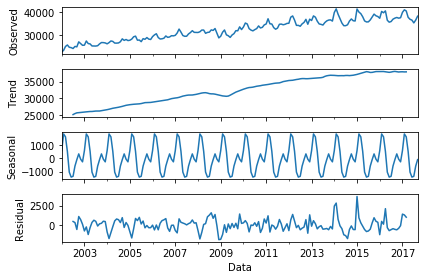

In [40]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train.Consumo).plot()
result = sm.tsa.stattools.adfuller(train.Consumo)
plt.show()

Podemos ver nos gráficos obtidos que esse conjunto de dados segue uma tendência crescente. Portanto, podemos usar a tendência linear de Holt para prever os preços futuros.

Holt estendeu a suavização exponencial simples para permitir a previsão de dados com uma tendência. Nada mais é do que a suavização exponencial aplicada ao nível (o valor médio da série) e à tendência. Para expressar isso em notação matemática, precisamos agora de três equações: uma para nível, uma para a tendência e uma para combinar o nível e a tendência para obter a previsão esperada.

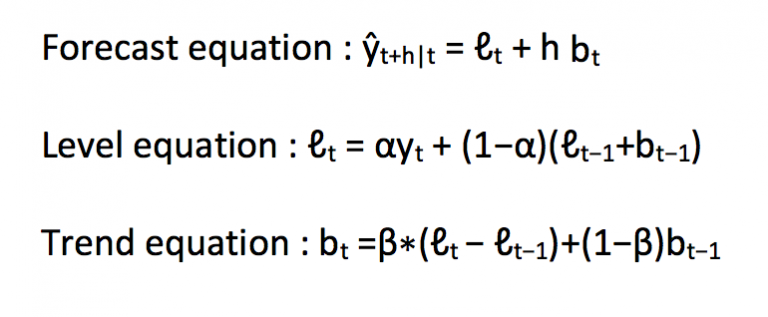

In [41]:
Image("img/TLH.png")

Os valores que previmos nos algoritmos acima são chamados Nível. Nas três equações acima, você pode observar que adicionamos nível e tendência para gerar a equação de previsão.

Assim como ocorre com a suavização exponencial simples, a equação de nível aqui mostra que é uma média ponderada de observação e a previsão de um passo à frente dentro da amostra. A equação de tendência mostra que é uma média ponderada da tendência estimada no tempo t com base em ℓ (t) −ℓ (t − 1) eb (t − 1), a estimativa anterior da tendência.

Adicionaremos essas equações para gerar a equação de previsão. Também podemos gerar uma equação de previsão multiplicativa multiplicando a tendência e o nível em vez de adicioná-lo. Quando a tendência aumenta ou diminui linearmente, a equação aditiva é usada, enquanto que quando a tendência aumenta diminui exponencialmente, a equação multiplicativa é usada. A prática mostra que multiplicativo é um preditor mais estável, mas o método aditivo é mais simples de entender.

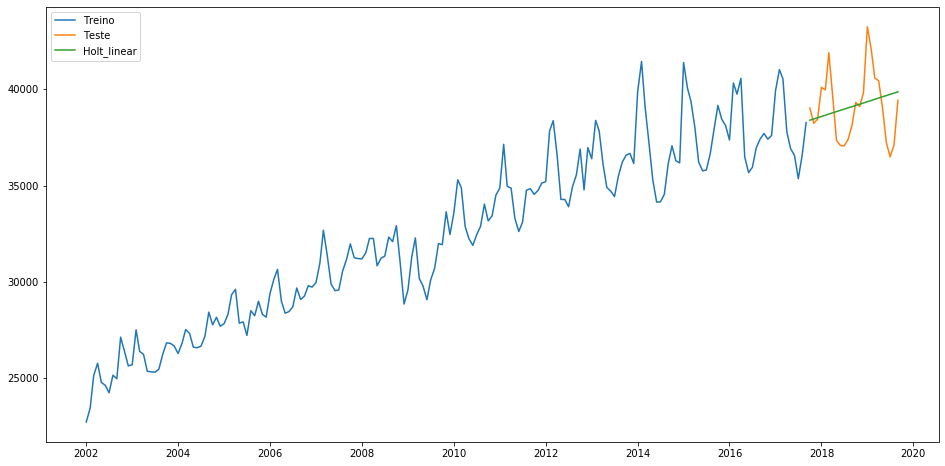

In [42]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Consumo'])).fit(smoothing_level = 0.1,smoothing_slope = 0.01)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['Consumo'], label='Treino')
plt.plot(test['Consumo'], label='Teste')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [43]:
rms = sqrt(mean_squared_error(test.Consumo, y_hat_avg.Holt_linear))
result_TLH = rms
result_TLH

1789.7779190027302

# Método 6 - Holt-Winters

Então, vamos introduzir um novo termo que será usado neste algoritmo. Considere um hotel localizado em uma estação de montanha. Ele experimenta visitas altas durante a temporada de verão, enquanto os visitantes durante o resto do ano são comparativamente muito menos. Portanto, o lucro obtido pelo proprietário será muito melhor na temporada de verão do que em qualquer outra temporada. Esse padrão se repetirá a cada ano. Essa repetição é chamada sazonalidade. Conjuntos de dados que mostram um conjunto semelhante de padrões após intervalos fixos de um período sofrem com a sazonalidade.

Os modelos mencionados acima não levam em consideração a sazonalidade do conjunto de dados durante a previsão. Portanto, precisamos de um método que leve em consideração a tendência e a sazonalidade para prever preços futuros. Um desses algoritmos que podemos usar nesse cenário é o método Holt-Winters. A ideia por trás da suavização exponencial tripla (inverno de Holt) é aplicar a suavização exponencial aos componentes sazonais, além de nível e tendência.

Usar o método Holt-Winters será a melhor opção entre os demais modelos, devido ao fator de sazonalidade. O método sazonal de Holt-Winters compreende a equação da previsão e três equações de suavização - uma para o nível ℓt, uma para a tendência bt e outra para o componente sazonal indicado por st, com os parâmetros de suavização α, β e γ.


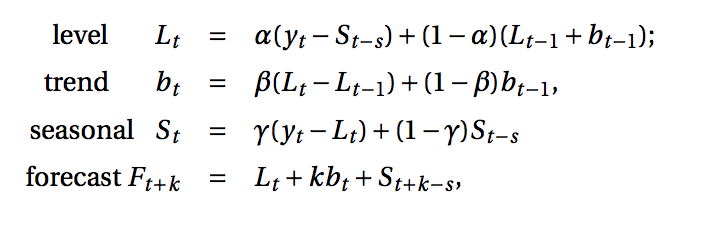

In [44]:
Image("img/HW.png")

onde s é a duração do ciclo sazonal, para 0 ≤ α ≤ 1, 0 ≤ β ≤ 1 e 0 ≤ γ ≤ 1.

A equação do nível mostra uma média ponderada entre a observação ajustada sazonalmente e a previsão não sazonal do tempo t. A equação da tendência é idêntica ao método linear de Holt. A equação sazonal mostra uma média ponderada entre o índice sazonal atual e o índice sazonal da mesma estação no ano passado (ou seja, s períodos atrás).

Também neste método, podemos implementar a técnica aditiva e a multiplicativa. O método aditivo é preferido quando as variações sazonais são aproximadamente constantes ao longo da série, enquanto o método multiplicativo é preferido quando as variações sazonais estão mudando proporcionalmente ao nível da série.
Vamos identificar qual a técnica mais apropriada para conseguir prever o Consumo de Energia para os próximos Anos.

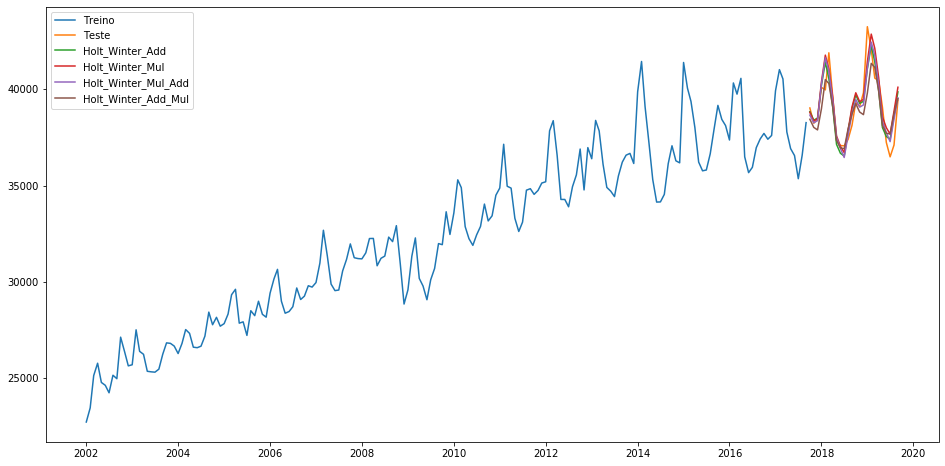

In [45]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Consumo']) ,seasonal_periods=12 ,trend='add', seasonal='add',).fit()
fit2 = ExponentialSmoothing(np.asarray(train['Consumo']) ,seasonal_periods=12 ,trend='mul', seasonal='add',).fit()
fit3 = ExponentialSmoothing(np.asarray(train['Consumo']) ,seasonal_periods=12 ,trend='add', seasonal='mul',).fit()
fit4 = ExponentialSmoothing(np.asarray(train['Consumo']) ,seasonal_periods=12 ,trend='mul', seasonal='mul',).fit()
y_hat_avg['Holt_Winter_Add'] = fit1.forecast(len(test))
y_hat_avg['Holt_Winter_Mul_Add'] = fit2.forecast(len(test))
y_hat_avg['Holt_Winter_Add_Mul'] = fit3.forecast(len(test))
y_hat_avg['Holt_Winter_Mul'] = fit4.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['Consumo'], label='Treino')
plt.plot(test['Consumo'], label='Teste')
plt.plot(y_hat_avg['Holt_Winter_Add'], label='Holt_Winter_Add')
plt.plot(y_hat_avg['Holt_Winter_Mul'], label='Holt_Winter_Mul')
plt.plot(y_hat_avg['Holt_Winter_Mul_Add'], label='Holt_Winter_Mul_Add')
plt.plot(y_hat_avg['Holt_Winter_Add_Mul'], label='Holt_Winter_Add_Mul')
plt.legend(loc='best')
plt.show()

In [46]:
y_hat_avg.head()

,Consumo,Holt_Winter_Add,Holt_Winter_Mul_Add,Holt_Winter_Add_Mul,Holt_Winter_Mul
Data,,,,,
2017-10-01,39024.64012,38832.957527,38654.429454,38439.549958,38800.410641
2017-11-01,38233.11639,38392.668804,38258.054079,38017.429377,38349.250199
2017-12-01,38434.79185,38498.428320,38368.328060,37885.749847,38468.955586
2018-01-01,40095.31798,40201.209945,40263.282747,38983.024031,40374.080889
2018-02-01,39962.42141,41396.503419,41628.318100,40497.094136,41768.713314


Olhando o gráfico é possível já identifica que o Forecast com sazonalidade multiplicativa se adaptou melhor a essa Série, mas vamos avaliar através da métrica RMSE

In [47]:
rms_Add = sqrt(mean_squared_error(test.Consumo, y_hat_avg.Holt_Winter_Add))
rms_Mul = sqrt(mean_squared_error(test.Consumo, y_hat_avg.Holt_Winter_Mul))

print(f'Holt_Winter_Add:: {rms_Add}\nHolt_Winter_Mul:: {rms_Mul}')


Holt_Winter_Add:: 825.2251369621318
Holt_Winter_Mul:: 866.6214958776561


In [48]:
rms_Add_Mul = sqrt(mean_squared_error(test.Consumo, y_hat_avg.Holt_Winter_Add_Mul))
rms_Mul_Add = sqrt(mean_squared_error(test.Consumo, y_hat_avg.Holt_Winter_Mul_Add))

print(f'Holt_Winter_Add_Mul:: {rms_Add_Mul}\nHolt_Winter_Mul_Add:: {rms_Mul_Add}')

Holt_Winter_Add_Mul:: 1026.887638274664
Holt_Winter_Mul_Add:: 782.5077258210052


Agora podemos comprovar o melhor modelo de previsão entre o Aditivo e o Multiplicativo. O valor do RMSE para os parâmetros de tendência Multiplicativa e sazonalidade Aditiva foi melhor, portanto vamos considera-lo como resultado.

In [49]:
rms = sqrt(mean_squared_error(test.Consumo, y_hat_avg.Holt_Winter_Mul_Add))
result_HW = rms
result_HW

782.5077258210052

Podemos ver no gráfico que o mapeamento de tendência e sazonalidade corretas fornece uma solução muito melhor. Escolhemos seasonal_period = 12, pois os dados se repetem anualmente. Outros parâmetros podem ser ajustados conforme o conjunto de dados.

# Método 7 - ARIMA

Outro modelo comum de série temporal muito popular entre os cientistas de dados é o ARIMA. Representa a média móvel integrada autorregressiva. Enquanto os modelos de suavização exponencial foram baseados em uma descrição de tendência e sazonalidade nos dados, os modelos ARIMA visam descrever as correlações nos dados entre si. Uma melhoria em relação ao ARIMA é o ARIMA sazonal (SARIMAX). Ele leva em consideração a sazonalidade do conjunto de dados, assim como o método Winter-Holt.

O ARIMA (Média Móvel Integrada Autoregressiva) é um modelo usado para prever tendências futuras em dados de séries temporais. É modelo essa forma de análise de regressão.
AR (Regressão automática): modelo que mostra uma variável variável que regride com seus próprios valores anteriores / atrasados.
I (Integrado): Diferença de observações brutas para permitir que as séries temporais se tornem estacionárias
MA (média móvel): dependência entre uma observação e um erro residual de um modelo de média móvel
Para modelos ARIMA, uma notação padrão seria ARIMA com p, deq, onde valores inteiros substituem os parâmetros para indicar o tipo de modelo ARIMA usado.

p: o número de observações de "lag" no modelo; também conhecido como a ordem de atraso.

d: o número de vezes que as observações brutas são diferenciadas; também conhecido como grau de diferenciação.

q: o tamanho da janela da média móvel; também conhecida como a ordem da média móvel.

Primeiro vamos tentar descobrir os melhores valores para as variáveis (p, d e q) através de um algorítimo chamado auto_arima, ele faz os testes na série temporal e devolve qual a melhor compbinação de valores para ser usado.

In [50]:
auto_arima(df['Consumo'], seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  213
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1775.124
Date:                            Sat, 23 Nov 2019   AIC                           3560.247
Time:                                    11:58:48   BIC                           3577.030
Sample:                                         0   HQIC                          3567.031
                                            - 213                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0167      0.100     -0.167      0.867      -0.213       0.180
ma.L1         -0.0863      0.043     -2.002      0.045      -0.171      -0.002
ar.S.L12       0.9997      0.002    515.648      0.000       0.996       1.003
ma.S.L12      -0.9890      0.034    -28.889      0.000      -1.056      -0.922
sigma2      9.972e+05   5.95e-08   1.68e+13      0.000    9.97e+05    9.97e+05
===================================================================================
Ljung-Box (Q):                       80.01   Jarque-Bera (JB):                11.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.33   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.6e+28. Standard errors may be unstable.
"""

Com os valores de Ordem e Sazonalidade, vamos treinar o modelo

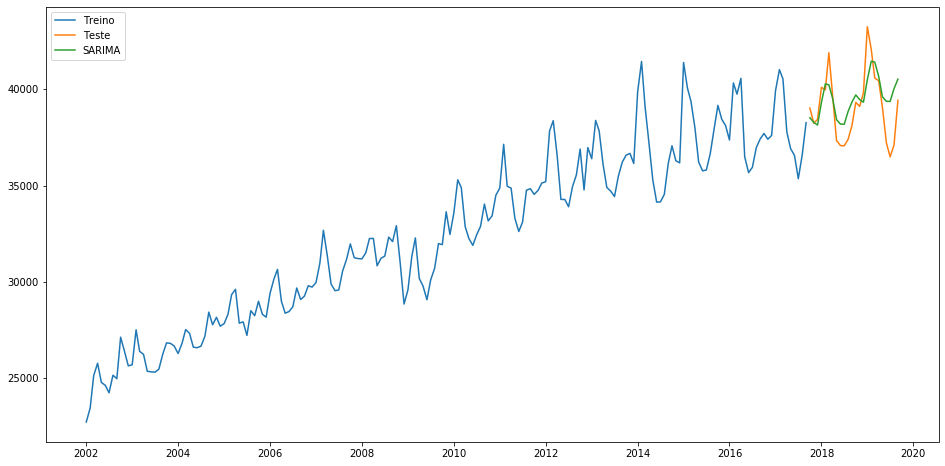

In [51]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Consumo, order=(0, 1, 1),seasonal_order=(1, 0, 1, 12)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start = len(train['Consumo']), end = len(df['Consumo'])-1, typ="levels", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(train['Consumo'], label='Treino')
plt.plot(test['Consumo'], label='Teste')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [52]:
rms = sqrt(mean_squared_error(test.Consumo, y_hat_avg.SARIMA))
result_ARIMA = rms
result_ARIMA

1341.2942337846987

# Médoto 8 - LSTM Neural Network

LSTM significa memória de longo prazo. É um modelo ou arquitetura que amplia a memória de redes neurais recorrentes. Normalmente, as redes neurais recorrentes têm 'memória de curto prazo', pois usam informações anteriores persistentes para serem usadas na rede neural atual. Essencialmente, as informações anteriores são usadas na tarefa atual. Isso significa que não temos uma lista de todas as informações anteriores disponíveis para o nó neural. 
O LSTM introduz memória de longo prazo em redes neurais recorrentes. Atenua o problema do gradiente de fuga, que é onde a rede neural para de aprender porque as atualizações para os vários pesos dentro de uma determinada rede neural se tornam cada vez menores. Isso é feito usando uma série de 'gates (Portões)'. Eles estão contidos em blocos de memória conectados através de camadas, assim:

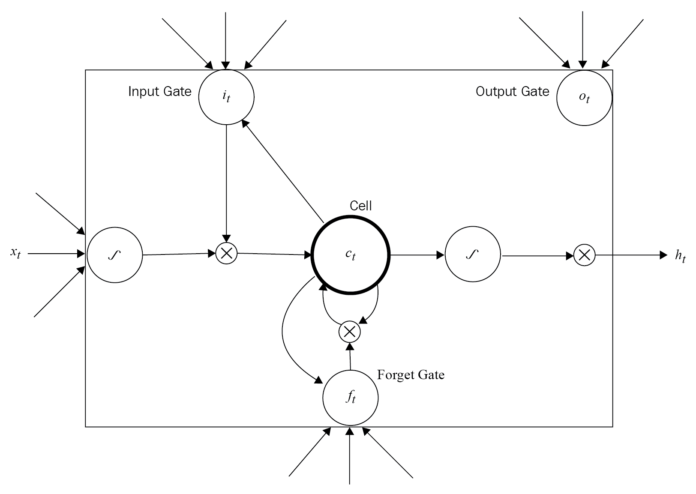

In [53]:
Image("img/LSTM.png")

LSTM trabalha com três tipos de portas em uma unidade: 

Portão de entrada: Dimensiona a entrada para a célula (gravação) 

Portão de saída: Dimensiona a saída para a célula (leitura) 

Portão de Esquecimento: Dimensiona o valor antigo da célula (redefinir) Cada portão é como um comutador que controla leitura / gravação, incorporando assim a função de memória de longo prazo no modelo.

In [54]:
def as_strided(series, window_size):
    n = len(series)
    X = np.array([series[i:i+window_size] for i in range(n-window_size)])
    y = np.array(series[window_size:])
    return X, y

In [55]:
n_steps = 12
n_features = 1
X, y = as_strided(df.Consumo, n_steps)
len_df = len(df)

In [56]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout

#.reshape(-1, n_steps, n_features)
X_train = X[:-24]
y_train = y[:-24]

std_X = X_train.std(axis=0).mean()

mean_train = X_train.mean(axis=1)
X_train = (X_train - mean_train.reshape(-1, 1))/std_X
y_train = (y_train - mean_train)/std_X
X_train = X_train.reshape(-1, n_steps, n_features)

X_test = X[-24:]
y_test = y[-24:]
mean_test = X_test.mean(axis=1)
X_test = (X_test - mean_test.reshape(-1, 1))/std_X
y_test = (y_test - mean_test)/std_X
X_test = X_test.reshape(-1, n_steps, n_features)

Using TensorFlow backend.


In [57]:
inputs = Input(shape=(n_steps, n_features))
lstm = LSTM(50, activation='relu')(inputs)
lstm = Dropout(0.5)(lstm)
outputs = Dense(1, activation='linear')(lstm)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.compile('adam', loss='mse', metrics=['mae'])

In [59]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=50, shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 177 samples, validate on 24 samples
Epoch 1/50
177/177 [==============================] - 1s 6ms/sample - loss: 0.1261 - mean_absolute_error: 0.2644 - val_loss: 0.1882 - val_mean_absolute_error: 0.3441
Epoch 2/50
177/177 [==============================] - 0s 849us/sample - loss: 0.1173 - mean_absolute_error: 0.2561 - val_loss: 0.1812 - val_mean_absolute_error: 0.3374
Epoch 3/50
177/177 [==============================] - 0s 710us/sample - loss: 0.1133 - mean_absolute_error: 0.2521 - val_loss: 0.1761 - val_mean_absolute_error: 0.3325
Epoch 4/50
177/177 [==============================] - 0s 699us/sample - loss: 0.1075 - mean_absolute_error: 0.2422 - val_loss: 0.1704 - val_mean_absolute_error: 0.3269
Epoch 5/50
177/177 [==============================] - 0s 716us/sample - loss: 0.1054 - mean_absolute_error: 0.2472 - val_loss: 0.1645 - val_mean_absolute_error: 0.3210
Epoch 6/50
177/177 [===

177/177 [==============================] - 0s 687us/sample - loss: 0.0589 - mean_absolute_error: 0.1844 - val_loss: 0.0548 - val_mean_absolute_error: 0.1805
Epoch 48/50
177/177 [==============================] - 0s 671us/sample - loss: 0.0558 - mean_absolute_error: 0.1767 - val_loss: 0.0540 - val_mean_absolute_error: 0.1803
Epoch 49/50
177/177 [==============================] - 0s 738us/sample - loss: 0.0680 - mean_absolute_error: 0.1943 - val_loss: 0.0586 - val_mean_absolute_error: 0.1804
Epoch 50/50
177/177 [==============================] - 0s 761us/sample - loss: 0.0636 - mean_absolute_error: 0.1862 - val_loss: 0.0518 - val_mean_absolute_error: 0.1787


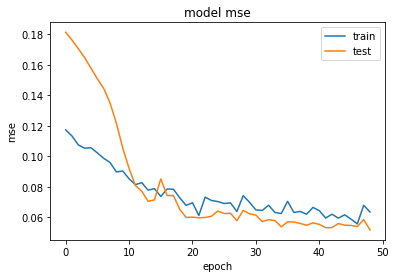

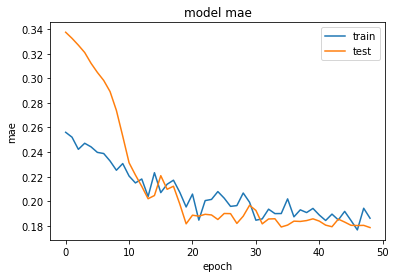

In [60]:
offset = 1

plt.plot(history.history['loss'][offset:], label='train')
plt.plot(history.history['val_loss'][offset:], label='test')
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend()
plt.show()

# summarize history for loss
plt.plot(history.history['mean_absolute_error'][offset:], label='train')
plt.plot(history.history['val_mean_absolute_error'][offset:], label='test')
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [61]:
y_pred = model.predict(X_test).reshape(-1)

In [62]:
evaluation = pd.DataFrame({'y_true': y_test, 'y_forecast': y_pred})
evaluation['y_true'] = evaluation.y_true * std_X + mean_test
evaluation['y_forecast'] = evaluation.y_forecast * std_X + mean_test
evaluation.head()

,y_true,y_forecast
0,39024.64012,38086.343107
1,38233.11639,38795.014760
2,38434.79185,39269.996652
3,40095.31798,39856.626207
4,39962.42141,40471.020834


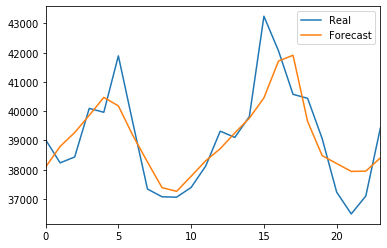

In [63]:
pd.Series(evaluation.y_true).plot(label='Real')
pd.Series(evaluation.y_forecast).plot(label='Forecast')
plt.legend()
plt.show()

In [64]:
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(evaluation.y_true, evaluation.y_forecast))

result_LSTM = rms
result_LSTM

965.2900150830052

# Método 9 - MLP (Multlayer Perceptron)

In [65]:
import tensorflow as tf
from numpy import array
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
n_steps = 12
n_features = 1
X, y = as_strided(df.Consumo, n_steps)
len_df = len(df)

In [67]:
X_train = X[:-24]
y_train = y[:-24]

std_X = X_train.std(axis=0).mean()

mean_train = X_train.mean(axis=1)
X_train = (X_train - mean_train.reshape(-1, 1))/std_X
y_train = (y_train - mean_train)/std_X
X_train = X_train.reshape(-1, n_steps)

X_test = X[-24:]
y_test = y[-24:]
mean_test = X_test.mean(axis=1)
X_test = (X_test - mean_test.reshape(-1, 1))/std_X
y_test = (y_test - mean_test)/std_X
X_test = X_test.reshape(-1, n_steps)

In [68]:
model = tf.keras.Sequential()
model.add(layers.Dense(200, activation='relu', input_dim=n_steps))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [69]:
model.fit(X_train, y_train, epochs=50, verbose=2)

Train on 177 samples
Epoch 1/50
177/177 - 0s - loss: 0.1352
Epoch 2/50
177/177 - 0s - loss: 0.0914
Epoch 3/50
177/177 - 0s - loss: 0.0675
Epoch 4/50
177/177 - 0s - loss: 0.0555
Epoch 5/50
177/177 - 0s - loss: 0.0512
Epoch 6/50
177/177 - 0s - loss: 0.0486
Epoch 7/50
177/177 - 0s - loss: 0.0461
Epoch 8/50
177/177 - 0s - loss: 0.0437
Epoch 9/50
177/177 - 0s - loss: 0.0415
Epoch 10/50
177/177 - 0s - loss: 0.0400
Epoch 11/50
177/177 - 0s - loss: 0.0386
Epoch 12/50
177/177 - 0s - loss: 0.0374
Epoch 13/50
177/177 - 0s - loss: 0.0365
Epoch 14/50
177/177 - 0s - loss: 0.0356
Epoch 15/50
177/177 - 0s - loss: 0.0351
Epoch 16/50
177/177 - 0s - loss: 0.0342
Epoch 17/50
177/177 - 0s - loss: 0.0334
Epoch 18/50
177/177 - 0s - loss: 0.0329
Epoch 19/50
177/177 - 0s - loss: 0.0324
Epoch 20/50
177/177 - 0s - loss: 0.0317
Epoch 21/50
177/177 - 0s - loss: 0.0315
Epoch 22/50
177/177 - 0s - loss: 0.0308
Epoch 23/50
177/177 - 0s - loss: 0.0305
Epoch 24/50
177/177 - 0s - loss: 0.0301
Epoch 25/50
177/177 - 0s - l

In [70]:
y_pred = model.predict(X_test).reshape(-1)

In [71]:
evaluation = pd.DataFrame({'y_true': y_test, 'y_forecast': y_pred})
evaluation['y_true'] = evaluation.y_true * std_X + mean_test
evaluation['y_forecast'] = evaluation.y_forecast * std_X + mean_test
evaluation.head()

,y_true,y_forecast
0,39024.64012,38856.177816
1,38233.11639,37999.214940
2,38434.79185,38591.796945
3,40095.31798,40231.742418
4,39962.42141,41440.036215


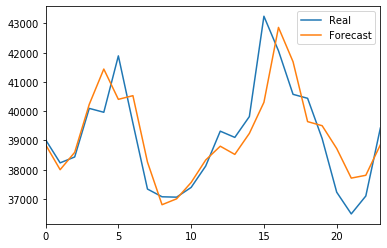

In [72]:
pd.Series(evaluation.y_true).plot(label='Real')
pd.Series(evaluation.y_forecast).plot(label='Forecast')
plt.legend()
plt.show()

In [88]:
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(evaluation.y_true, evaluation.y_forecast))

result_MLP = rms
result_MLP

984.4030106982646

# Método 10 - Prophet
Prophet é um procedimento para prever dados de séries temporais com base em um modelo aditivo no qual tendências não lineares se ajustam à sazonalidade anual, semanal e diária, além de efeitos de férias. Funciona melhor com séries temporais que têm fortes efeitos sazonais e várias temporadas de dados históricos. O Prophet é robusto para a falta de dados e mudanças na tendência e normalmente lida bem com discrepantes.

In [74]:
df_pr = df.copy()
df_pr = df.reset_index()
df_pr.columns = ['ds','y'] # OS NOMES DAS VARIÁVEIS DEVE SER ESSES
train_data_pr = df_pr.iloc[:len(df)-24]
test_data_pr = df_pr.iloc[len(df)-24:]
from fbprophet import Prophet
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=24,freq='MS')
prophet_pred = m.predict(future)
prophet_pred.tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
208,2019-05-01,39263.749775,37276.694004,39697.426761,39179.593510,39326.483048,-799.796371,-799.796371,-799.796371,-799.796371,-799.796371,-799.796371,0.0,0.0,0.0,38463.953403
209,2019-06-01,39303.971520,36716.808051,39258.927636,39214.828726,39371.341679,-1292.188691,-1292.188691,-1292.188691,-1292.188691,-1292.188691,-1292.188691,0.0,0.0,0.0,38011.782829
210,2019-07-01,39342.895790,36744.103803,39156.234949,39247.019761,39417.253553,-1342.523748,-1342.523748,-1342.523748,-1342.523748,-1342.523748,-1342.523748,0.0,0.0,0.0,38000.372041
211,2019-08-01,39383.117535,37530.483954,39915.777926,39280.750436,39463.771054,-635.003875,-635.003875,-635.003875,-635.003875,-635.003875,-635.003875,0.0,0.0,0.0,38748.113660
212,2019-09-01,39423.339281,38112.435439,40526.021478,39316.115938,39510.459462,-128.050116,-128.050116,-128.050116,-128.050116,-128.050116,-128.050116,0.0,0.0,0.0,39295.289165


In [75]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-24:]['ds'], "Pred" : prophet_pred[-24:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "MS"
prophet_pred

,Pred
Date,
2017-10-01,38956.709281
2017-11-01,38540.606762
2017-12-01,38345.038175
2018-01-01,39131.166334
2018-02-01,40323.628811
2018-03-01,40250.958553
2018-04-01,39237.529245
2018-05-01,37885.856009
2018-06-01,37516.117733


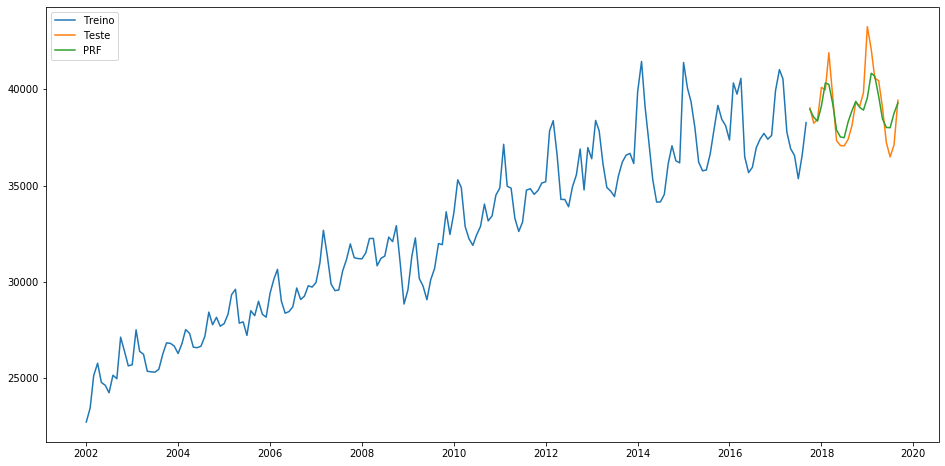

In [76]:
y_hat_avg['PRF'] = prophet_pred
plt.figure(figsize=(16,8))
plt.plot(train['Consumo'], label='Treino')
plt.plot(test['Consumo'], label='Teste')
plt.plot(y_hat_avg['PRF'], label='PRF')
plt.legend(loc='best')
plt.show()

In [77]:
rms = sqrt(mean_squared_error(test.Consumo, y_hat_avg.PRF))
result_PRF = rms
result_PRF

1093.076729670316

In [112]:
results = pd.DataFrame({
    'Model': ['Abordagem Simples', 
              'Média Simples', 
              'Média Móvel', 
              'Suavização exponencial', 
              'Tendência linear de Holt', 
              'Holt-Winters', 
              'ARIMA', 
              'LSTM',
              'MLP',
              'Prophet'],
    'Score': [result_NA, result_SA, result_MA, result_SES, result_TLH, result_HW, result_ARIMA, result_LSTM, result_MLP, result_PRF]})

result_df = results.sort_values(by='Score', ascending=True)
result_df = result_df.set_index('Score')
result_df.head(10)

,Model
Score,
782.50773,Holt-Winters
965.29002,LSTM
984.40301,MLP
1093.07673,Prophet
1341.29423,ARIMA
1789.77792,Tendência linear de Holt
1836.64848,Suavização exponencial
1908.14615,Abordagem Simples
2053.26302,Média Móvel


Como podemos ver, o Modelo Holt-Winters foi o mais se ajustou a essa série, portanto usaremos ele para fazer uma previsão para os próximos dois anos (2020 e 2021)

In [79]:
best_model = ExponentialSmoothing(np.asarray(train['Consumo']), 
                                  seasonal_periods=12, trend='mul', seasonal='add').fit()

Analisando os Parametros do Modelo

In [80]:
pd.options.display.float_format = '{:.5f}'.format
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Holt-Winters Multiplicative"]  = [best_model.params[p] for p in params] + [best_model.sse]
results

,Holt-Winters Multiplicative
$\alpha$,0.24171
$\beta$,0.00005
$\phi$,nan
$\gamma$,0.42764
$l_0$,31844.96407
$b_0$,1.00147
SSE,178918784.20043


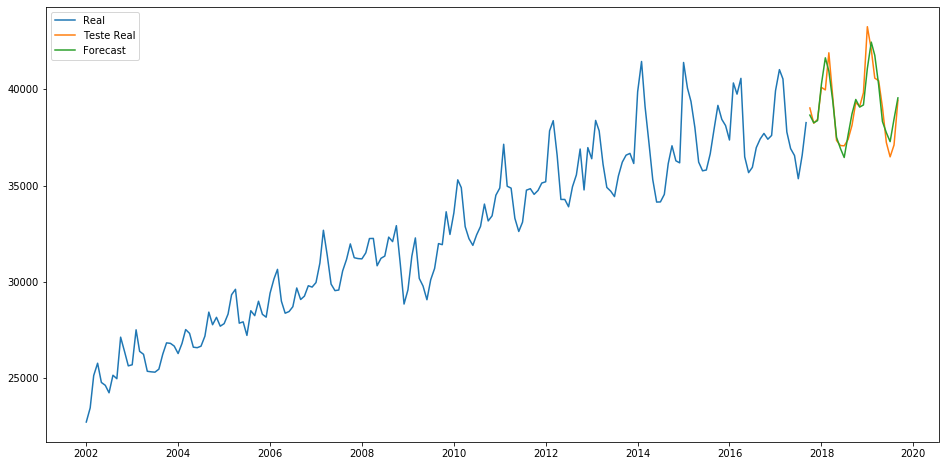

In [81]:
data_train = train['Consumo']

prev = pd.Series(best_model.forecast(len(test)), index=test.index)

plt.figure(figsize=(16,8))
plt.plot(data_train, label='Real')
plt.plot(test['Consumo'], label='Teste Real')
plt.plot(prev, label='Forecast')
plt.legend()
plt.show()


Agora vamos Pegar os Resíduos para calcular os Limietes Superior e Inferior do Forecast da Série

In [82]:
std_err = pd.Series(prev.values.reshape(-1) - test.values.reshape(-1)).std()
lower = (prev - 1.96 * std_err).reset_index(drop=True)
upper = (prev + 1.96 * std_err).reset_index(drop=True)

Estrapolando o Forecast para os Proximos 2 Anos

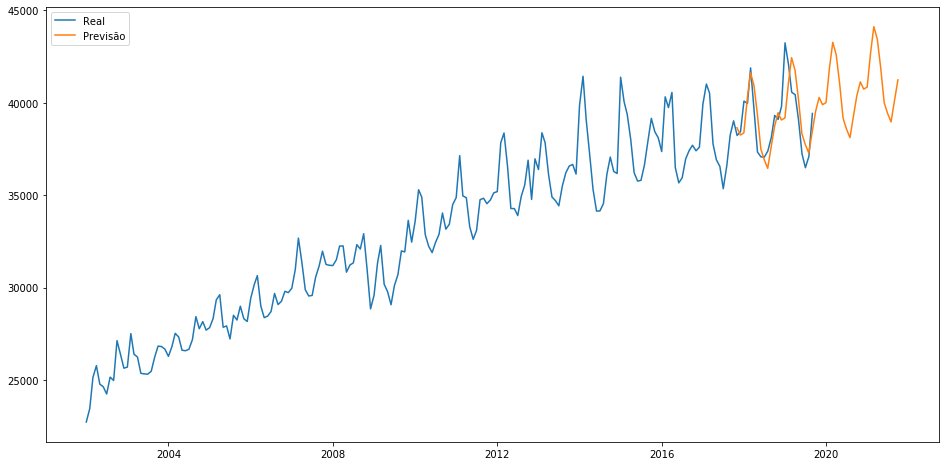

In [83]:
periods = len(test)+24
prev_2020 = pd.Series(best_model.forecast(periods),
                  index=pd.date_range(test.index.min(), periods=periods, freq='M'))

plt.figure(figsize=(16,8))
plt.plot(df, label='Real')
plt.plot(prev_2020, label='Previsão')
plt.legend()
plt.show()

Plotando os Residuos:

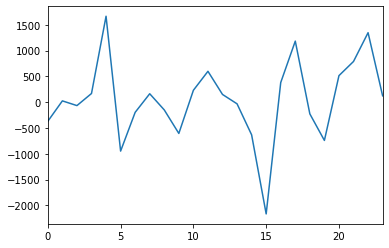

In [84]:
residuos = pd.Series(prev.values.reshape(-1) - test.values.reshape(-1))
residuos.plot()

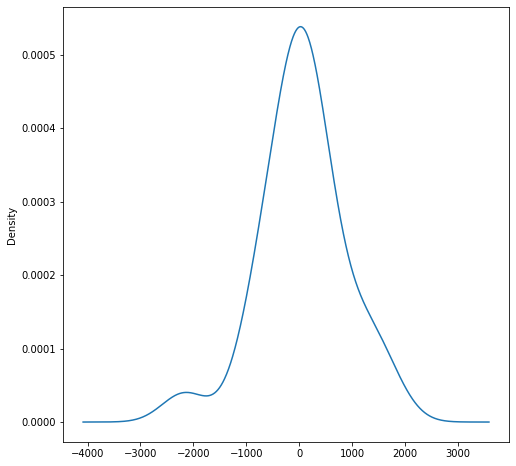

In [119]:
residuos.plot(kind='density', subplots=True, sharex=False, figsize = (8,8))
plt.show()

Plotando os dados com os Limites encontrados

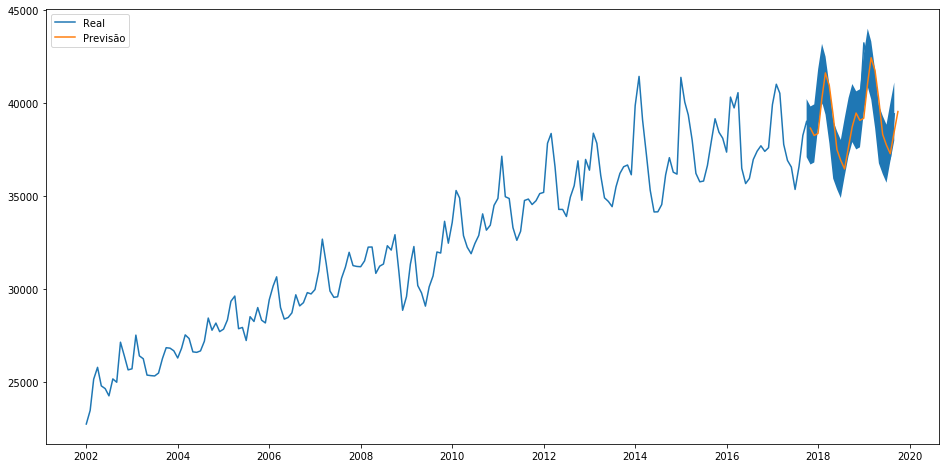

In [90]:
periods = len(test)
prev = pd.Series(best_model.forecast(periods),
                  index=pd.date_range(test.index.min(), periods=periods, freq='M'))

plt.figure(figsize=(16,8))
plt.plot(df, label='Real')
plt.plot(prev, label='Previsão')
plt.fill_between(test.index, lower, upper)
plt.legend()
plt.show()

In [91]:
std_err

797.7105890378194

Agora vamos fazer uma previsão para os príxmos 2 anos usando o Modelo

In [92]:
periods = 24
prev_2020 = pd.Series(best_model.forecast(periods),
                  index=pd.date_range('2019-12-01 00:00:00', periods=periods, freq='M'))

In [93]:
from datetime import datetime

In [94]:
lower = (prev_2020 - 1.96 * std_err).reset_index(drop=True)
upper = (prev_2020 + 1.96 * std_err).reset_index(drop=True)

forecast_df = prev_2020.reset_index()
forecast_df.columns = ['date', 'consumo']
forecast_df['limite_inferior'] = lower
forecast_df['limite_superior'] = upper

In [95]:
forecast_df.head()

,date,consumo,limite_inferior,limite_superior
0,2019-12-31,38654.42945,37090.91670,40217.94221
1,2020-01-31,38258.05408,36694.54132,39821.56683
2,2020-02-29,38368.32806,36804.81531,39931.84081
3,2020-03-31,40263.28275,38699.76999,41826.79550
4,2020-04-30,41628.31810,40064.80535,43191.83085


In [96]:
forecast_df_2020 = forecast_df[forecast_df.date >= datetime(2019, 12, 1)]
forecast_df_2020

,date,consumo,limite_inferior,limite_superior
0,2019-12-31,38654.42945,37090.91670,40217.94221
1,2020-01-31,38258.05408,36694.54132,39821.56683
2,2020-02-29,38368.32806,36804.81531,39931.84081
3,2020-03-31,40263.28275,38699.76999,41826.79550
4,2020-04-30,41628.31810,40064.80535,43191.83085
5,2020-05-31,40941.58601,39378.07325,42505.09876
6,2020-06-30,39394.05864,37830.54588,40957.57139
7,2020-07-31,37501.11904,35937.60628,39064.63179
8,2020-08-31,36923.17203,35359.65928,38486.68479
9,2020-09-30,36454.21986,34890.70711,38017.73261


In [97]:
forecast_df_2020 = forecast_df_2020.set_index("date")

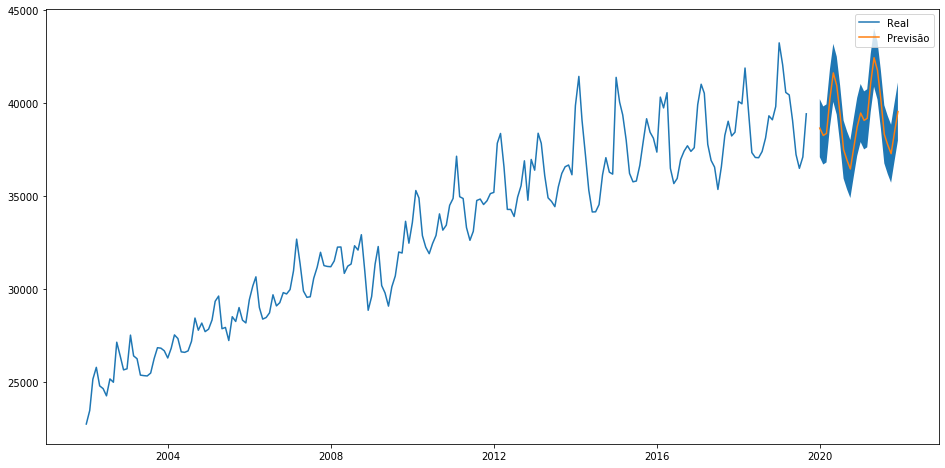

In [98]:
plt.figure(figsize=(16,8))
plt.plot(df, label='Real')
plt.plot(forecast_df_2020['consumo'], label='Previsão')
plt.fill_between(forecast_df_2020.index, forecast_df_2020['limite_inferior'], forecast_df_2020['limite_superior'])
plt.legend()
plt.show()